Create the bipartite network

In [9]:
import networkx as nx
from networkx.algorithms import bipartite
import pickle
from os import listdir
from os.path import isfile, join
from collections import *

PROCESSED_PATH = "random_stock_tweets/processed/"
STOCK_PATH = "random_stock_tweets/"
USER_PATH = "random_stock_users/"


def load_stock(stock):
	with open(STOCK_PATH+stock, 'r') as f:
		return pickle.load(f)
def load_user(user):
	with open(USER_PATH+user, 'r') as f:
		return pickle.load(f)

stocks = {f: load_stock(f) for f in listdir(STOCK_PATH) if isfile(join(STOCK_PATH,f))}
users = {f: load_user(f) for f in listdir(USER_PATH) if isfile(join(USER_PATH, f))}

# Bipartite graphs in networkx are implemented using a normal graph where nodes have an attribute
# value of either 0 or 1 depending on which graph it belongs to

G = nx.Graph()
# Add all stocks
G.add_nodes_from(stocks.keys(), bipartite=0)
# Add all users
G.add_nodes_from(users.keys(), bipartite=1)
for (symbol, stock_tweets) in stocks.iteritems():
	# Find the users that tweeted about this stock
	user_ids = set([tweet.author.id_str for tweet in stock_tweets])
	G.add_edges_from([(symbol, user) for user in user_ids if user in users.keys()])

# Create the user network from the bipartite network
stock_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==0)
user_nodes = set(G) - stock_nodes

An interesting attribute of the user network is how many stocks each user has in common. We retain this by using a weighted network graph.

In [10]:
U = bipartite.overlap_weighted_projected_graph(G, user_nodes)

From this we can recover the giant connected component to investigate further

In [11]:
components = list(nx.connected_component_subgraphs(U))
for c in components:
    print "Elements in component: {}".format(len(c))
U_max = max(components, key=len)

Elements in component: 5158
Elements in component: 94
Elements in component: 97
Elements in component: 137
Elements in component: 94
Elements in component: 99
Elements in component: 100
Elements in component: 72
Elements in component: 92
Elements in component: 87
Elements in component: 99
Elements in component: 77
Elements in component: 74
Elements in component: 78
Elements in component: 1
Elements in component: 77
Elements in component: 94
Elements in component: 71
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 86
Elements in component: 1
Elements in component: 6
Elements in component: 93
Elements in component: 51
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 162
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 96
Elements in component: 36
Elements in component:

Drawing this shows a highly connected graph with several nodes connected only by a single neighbor

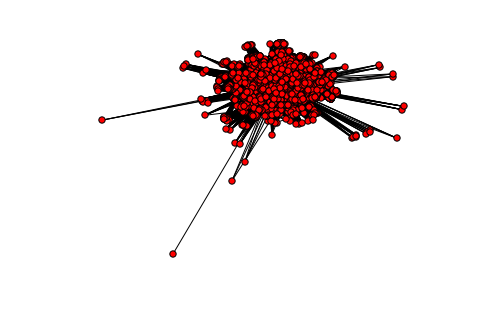

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
nx.draw(U_max, node_size = 40, figsize=(20,10))

To investigate the nature of the graph the degree distribution is plotted

In [12]:
def plotLogDegree(graph):
    d = Counter(G.degree())
    y = Counter(d.values()).values()
    x = sorted(set(d.values()))
    plt.loglog(x,y, 'ro-') # Plot the in degree distribution
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.show()

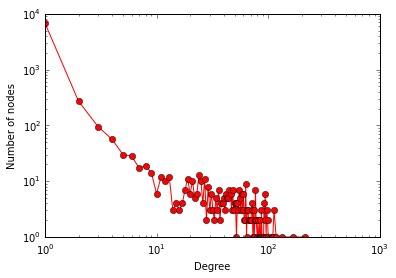

In [13]:
plotLogDegree(U_max)

This shows us that a lot of the nodes are single connected nodes. This is not ideal for our assumption of a network where several twitter accounts are owned by the same people and tweeting in unison.

We can now see if it's possible to find communities based on what stocks the users tweet about. Clear communities would point to twitter accounts owned by the same people.

In [14]:
import community
partition = community.best_partition(U_max)
print "Modularity for the GCC using Louvain algorithm: {}".format(community.modularity(partition, U_max))

Modularity for the GCC using Louvain algorithm: 0.935133430972


Although this shows that the algorithm is able to find commuities it is not unambiguous. The modularity being greater than 0 can also be because of hubs in the network connecting otherwise unconnected users.

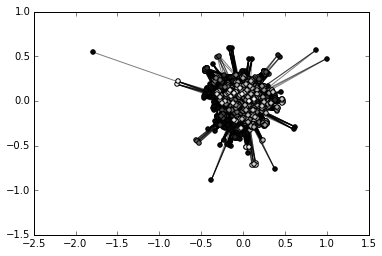

In [137]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(U_max)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(U_max, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(U_max,pos, alpha=0.5, fig_size=(20,10))

Looking at the sizes of our communities it seems they are all actually significant, all communities have double digits members.

In [15]:
partition_inv = {v:[] for v in set(partition.values())}
map(lambda tup: partition_inv[tup[1]].append(tup[0]), partition.items())
for (k,v) in partition_inv.iteritems():
    print "Partition {} has length {}".format(k,len(v))

Partition 0 has length 39
Partition 1 has length 1019
Partition 2 has length 77
Partition 3 has length 107
Partition 4 has length 24
Partition 5 has length 72
Partition 6 has length 75
Partition 7 has length 47
Partition 8 has length 136
Partition 9 has length 56
Partition 10 has length 21
Partition 11 has length 89
Partition 12 has length 150
Partition 13 has length 18
Partition 14 has length 250
Partition 15 has length 76
Partition 16 has length 22
Partition 17 has length 142
Partition 18 has length 65
Partition 19 has length 145
Partition 20 has length 89
Partition 21 has length 93
Partition 22 has length 74
Partition 23 has length 29
Partition 24 has length 51
Partition 25 has length 124
Partition 26 has length 92
Partition 27 has length 66
Partition 28 has length 59
Partition 29 has length 70
Partition 30 has length 46
Partition 31 has length 34
Partition 32 has length 65
Partition 33 has length 32
Partition 34 has length 42
Partition 35 has length 90
Partition 36 has length 81
Pa

In [16]:
U_com = community.induced_graph(partition, U_max)
nx.draw_networkx_edges(U_com)

TypeError: draw_networkx_edges() takes at least 2 arguments (1 given)

In [22]:
partition_inv[48]

['242773902',
 '2215941074',
 u'3076004156',
 u'2876239853',
 u'3171314778',
 u'264774473',
 '3003619042',
 '2953041241',
 u'3683302942',
 u'2941303565',
 '178908548',
 u'2465357504',
 '3276436574',
 u'3227631494',
 u'511011887',
 u'2485472700',
 u'2492626010',
 '2658188018',
 '2952980612',
 '2512824006',
 '3047874156',
 u'1936272216',
 '1150654639',
 u'3429168183',
 u'1265137206',
 u'2341775859',
 u'3054166658',
 u'3042907337',
 u'2268981182',
 u'1784300431',
 u'59751846',
 u'1319847740',
 u'2482964762',
 u'2907070473',
 u'2511361022',
 u'3178152246',
 u'3041182410',
 u'2843390680',
 u'2180509219',
 u'3428633417',
 u'2907090723',
 u'1663038788',
 u'3701853616',
 u'36611777',
 u'2530160988',
 u'2721671976',
 u'512331482',
 u'3011886320',
 u'243133079',
 u'2670548227',
 u'854394624',
 u'776568883',
 u'308051942',
 u'291600298',
 u'3235895686']

In [26]:
G.nodes(['2492626010', '3227631494'])

[('XCOM', {'bipartite': 0}),
 ('329698600', {'bipartite': 1}),
 ('1462502023', {'bipartite': 1}),
 ('3303022437', {'bipartite': 1}),
 ('170835124', {'bipartite': 1}),
 ('2313537198', {'bipartite': 1}),
 ('2275637174', {'bipartite': 1}),
 ('294466649', {'bipartite': 1}),
 ('3181492070', {'bipartite': 1}),
 ('2962811818', {'bipartite': 1}),
 ('23765964', {'bipartite': 1}),
 ('121690916', {'bipartite': 1}),
 ('746738408', {'bipartite': 1}),
 ('397402573', {'bipartite': 1}),
 ('3330071746', {'bipartite': 1}),
 ('SPU', {'bipartite': 0}),
 ('PHMD', {'bipartite': 0}),
 ('2605083583', {'bipartite': 1}),
 ('DHXM', {'bipartite': 0}),
 ('19840177', {'bipartite': 1}),
 ('1132026678', {'bipartite': 1}),
 ('1458164083', {'bipartite': 1}),
 ('3107807142', {'bipartite': 1}),
 ('2628090567', {'bipartite': 1}),
 ('2190052534', {'bipartite': 1}),
 ('242773902', {'bipartite': 1}),
 ('788502499', {'bipartite': 1}),
 ('567113946', {'bipartite': 1}),
 ('149232979', {'bipartite': 1}),
 ('2687684474', {'bipart

In [ ]:
def get_common_stocks(user_ids):
    

To remove some noise from our network we can trim away connections between users that only shared something like a single stock. This will make sure that very popular stocks such as Apple will not influence the results, since everybody tweets about them without that meaning that the users necessarily are grouped. To find a decent cutoff weight it is a good idea to look at the distribution of weights.

In [172]:
from collections import *
def plotWeightDistribution(G):
    c = Counter([attrib['weight'] for (node,edges) in G.edge.iteritems() for (_, attrib) in edges.iteritems()])
    x,y=zip(*[(k,c[k]) for k in sorted(c)])
    plt.loglog(x,y, 'ro') # Plot the in degree distribution
    plt.xlabel('Weight')
    plt.ylabel('Number of nodes')
    plt.show()

In [158]:
u=Counter([attrib['weight'] for (node,edges) in U_max.edge.iteritems() for (_, attrib) in edges.iteritems()]) 
x,y=zip(*[(k,u[k]) for k in sorted(u)])

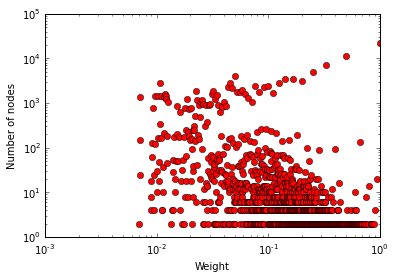

In [173]:
plotWeightDistribution(U_max)

The almost log linear plot indicates that a large part of our edges is based on users having very few stocks in common in their tweets. We can try decimating the network by removing edges below different thresholds to investigate further.

In [113]:
U_dec1 = U.copy()
one_neighbour_edges = [(node, edge_node) for (node,edges) in U_max.edge.iteritems() for (edge_node, attrib) in edges.iteritems() if attrib['weight'] < 2]
U_dec1.remove_edges_from(one_neighbour_edges)
components = list(nx.connected_component_subgraphs(U_dec1))
for c in components:
    if len(c) > 1:
        print "Elements in component: {}".format(len(c))
U_dec1_max = max(components, key=len)

Elements in component: 426


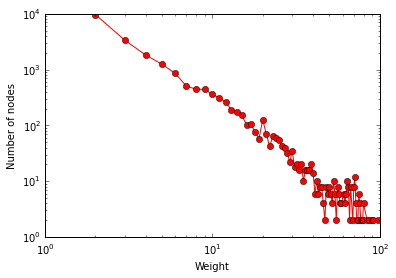

In [114]:
plotWeightDistribution(U_dec1_max)

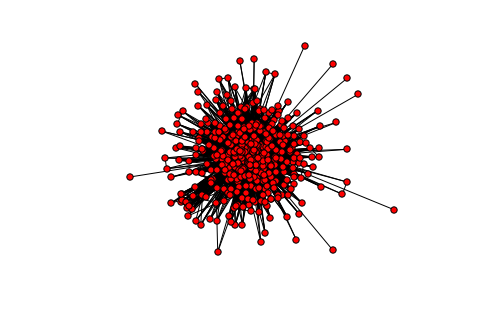

In [115]:
nx.draw(U_dec1_max, node_size=40)

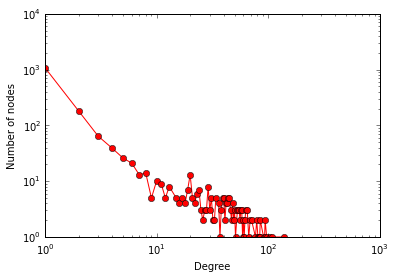

In [116]:
plotLogDegree(U_dec1_max)

In [117]:
partition = community.best_partition(U_dec1_max)
print "Modularity for the GCC using Louvain algorithm: {}".format(community.modularity(partition, U_dec1_max))

Modularity for the GCC using Louvain algorithm: 0.116737909713


In [121]:
cliques=[c for c in nx.find_cliques(G)]

In [123]:
len(cliques)

5400